# Introduction

In this notebook, I will analyse the Seattle AirBNB Dataset from Inside AirBnb. I will follow the **CRISP-DM process** when analysing their data. The CRISP-DM stages are:

1. Business Understanding
1. Data Understanding
1. Data Preparation
1. Modelling
1. Evaluation
1. Deployment

![](../data/raw/crisp_dm_image.jpg)

# Business Understanding
    
In this project, a mail-order sales company in Germany is interested in identifying **segments of the general population to target** with their marketing in order to grow. The objective is to identify which individuals are most likely to respond to the campaign and become customers of the mail-order company.

In this section, I will first focus on identifying the parts on the population that **best describe the core customer base** of the company **using customer segmentation**.

# Data Understanding

In this step, I will focus on understanding the Arvato and Germany Demographics data. I will do this as follows:
1. Go step by step through the Data Dictionaries: [DIAS Attributes - Values 2017](../data/raw/DIAS%20Attributes%20-%20Values%202017.xlsx) and [DIAS Information Levels - Attributes 2017](../data/raw/DIAS%20Information%20Levels%20-%20Attributes%202017.xlsx) sheets.
1. Create Pandas Profiling reports and analyse them i.e. [Geramany Pop Demographics Report](../data/raw/population_demographics.html) and [Customer Demographics Report](../data/raw/customer_demographics.html)
1. Note down **observations** and **action points** from Analysis

## Load Datasets

In [1]:
import pandas as pd
import numpy as np
import pandas_profiling as pp
import matplotlib.pyplot as plt

pd.set_option("display.max_columns",50)
%matplotlib inline

home_dir = '../'
data_dir = home_dir + 'data/'
raw_dir = data_dir + 'raw/'
processed_dir = data_dir + 'processed/'

In [2]:
%%time
customer_demographics = pd.read_csv(raw_dir + 'Udacity_CUSTOMERS_052018.csv', sep=';', low_memory=False)
population_demographics = pd.read_csv(raw_dir + 'Udacity_AZDIAS_052018.csv', sep=';', low_memory=False)

Wall time: 1min 21s


## Generate Pandas Profiling Reports

In [4]:
kwargs = dict(correlations={
        "pearson": {"calculate": False, 'warn_high_correlations': True},
        "spearman": {"calculate": False, 'warn_high_correlations': True},
        "kendall": {"calculate": False, 'warn_high_correlations': False},
        "phi_k": {"calculate": False, 'warn_high_correlations': False},
        "cramers": {"calculate": False, 'warn_high_correlations': False},
    }, missing_diagrams=None, interactions=None)

In [10]:
%%time
pp.ProfileReport(customer_demographics, title='Arvato Customer Demographics', **kwargs).to_file(raw_dir + 'customer_demographics.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Wall time: 3min 34s


In [6]:
%%time
pp.ProfileReport(population_demographics, title='Germany Population Demographics', **kwargs).to_file(raw_dir + 'population_demographics.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Wall time: 12min 56s


## Observations

1. The Demographics data uses **PLZ8 data**. You can find more info in it [here](https://www.regionale-marktdaten.de/plz8/) or [here](https://ddsgeo.com/download/flyer/PLZ8_eng_Flyer.pdf).
1. It also uses **grid data**. You can find more info on this dataset [here](https://www.regionale-marktdaten.de/az-deutschland-raster/).
1. It also has records of Information Level RR1_ID, RR3_ID and RR4_ID which are all different **spatial levels**. RR3_ID and RR4_ID are all associated with the **microcell level**, however I could not find a concise explanation for this spatial level beyond a small geographic area covered by a cellular carrier or some other transmission system.
1. Many features have a large proportion of unknown values i.e. -1 or 0
1. The features are too many to manually asses and drop.

## Action Points
1. Feed datasets with minimal data cleanin and transformation to algorithms to discover important features.

# Data Preparation

In this section, I clean and transform the Demographics data in preparation for clustering with HDBSCAN

In [3]:
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer, Normalizer, LabelEncoder

In [4]:
all_known_columns = "AGER_TYP,ALTERSKATEGORIE_GROB,ALTER_HH,ANREDE_KZ,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,BIP_FLAG,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_DEUINTL_2015,CJT_GESAMTTYP,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT_RZ,D19_BANKEN_GROSS_RZ,D19_BANKEN_LOKAL_RZ,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST_RZ,D19_BEKLEIDUNG_GEH_RZ,D19_BEKLEIDUNG_REST_RZ,D19_BILDUNG_RZ,D19_BIO_OEKO_RZ,D19_BUCH_RZ,D19_DIGIT_SERV_RZ,D19_DROGERIEARTIKEL_RZ,D19_ENERGIE_RZ,D19_FREIZEIT_RZ,D19_GARTEN_RZ,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK_RZ,D19_HAUS_DEKO_RZ,D19_KINDERARTIKEL_RZ,D19_KONSUMTYP,D19_KK_KUNDENTYP,D19_KOSMETIK_RZ,D19_LEBENSMITTEL_RZ,D19_LOTTO_RZ,D19_NAHRUNGSERGAENZUNG_RZ,D19_RATGEBER_RZ,D19_REISEN_RZ,D19_SAMMELARTIKEL_RZ,D19_SCHUHE_RZ,D19_SONSTIGE_RZ,D19_TECHNIK_RZ,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE_RZ,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_REST_RZ,D19_TIERARTIKEL_RZ,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST_RZ,D19_VERSICHERUNGEN_RZ,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VOLLSORTIMENT_RZ,D19_WEIN_FEINKOST_RZ,EWDICHTE,FINANZTYP,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GFK_URLAUBERTYP,GEOSCORE_KLS7,GREEN_AVANTGARDE,HAUSHALTSSTRUKTUR,HEALTH_TYP,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_0_1400,KBA13_CCM_1500,KBA13_CCM_1400_2500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_180,KBA13_KMH_0_140,KBA13_KMH_140_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_0_60,KBA13_KW_70,KBA13_KW_61_120,KBA13_KW_80,KBA13_KW_90,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13_PEUGEOT,KBA13_RENAULT,KBA13_SEG_GELAENDEWAGEN,KBA13_SEG_GROSSRAUMVANS,KBA13_SEG_KLEINST,KBA13_SEG_KLEINWAGEN,KBA13_SEG_KOMPAKTKLASSE,KBA13_SEG_MINIVANS,KBA13_SEG_MINIWAGEN,KBA13_SEG_MITTELKLASSE,KBA13_SEG_OBEREMITTELKLASSE,KBA13_SEG_OBERKLASSE,KBA13_SEG_SONSTIGE,KBA13_SEG_SPORTWAGEN,KBA13_SEG_UTILITIES,KBA13_SEG_VAN,KBA13_SEG_WOHNMOBILE,KBA13_SITZE_4,KBA13_SITZE_5,KBA13_SITZE_6,KBA13_TOYOTA,KBA13_VORB_0,KBA13_VORB_1,KBA13_VORB_1_2,KBA13_VORB_2,KBA13_VORB_3,KBA13_VW,KKK,KONSUMNAEHE,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,MIN_GEBAEUDEJAHR,MOBI_REGIO,NATIONALITAET_KZ,ONLINE_AFFINITAET,ORTSGR_KLS9,OST_WEST_KZ,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_GBZ,PLZ8_HHZ,PRAEGENDE_JUGENDJAHRE,REGIOTYP,RELAT_AB,RETOURTYP_BK_S,SEMIO_DOM,SEMIO_ERL,SEMIO_FAM,SEMIO_KAEM,SEMIO_KRIT,SEMIO_KULT,SEMIO_LUST,SEMIO_MAT,SEMIO_PFLICHT,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,SOHO_FLAG,TITEL_KZ,VERS_TYP,WOHNDAUER_2008,WOHNLAGE,WACHSTUMSGEBIET_NB,W_KEIT_KIND_HH,ZABEOTYP".split(',')

numerical_features = 'ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,KBA13_ANZAHL_PKW,clusters_prob'.split(',')
ordinal_features = "BALLRAUM,CAMEO_DEUG_2015,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT_RZ,D19_BANKEN_GROSS_RZ,D19_BANKEN_LOKAL_RZ,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST_RZ,D19_BEKLEIDUNG_GEH_RZ,D19_BEKLEIDUNG_REST_RZ,D19_BILDUNG_RZ,D19_BIO_OEKO_RZ,D19_BUCH_RZ,D19_DIGIT_SERV_RZ,D19_DROGERIEARTIKEL_RZ,D19_ENERGIE_RZ,D19_FREIZEIT_RZ,D19_GARTEN_RZ,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK_RZ,D19_HAUS_DEKO_RZ,D19_KINDERARTIKEL_RZ,D19_KOSMETIK_RZ,D19_LEBENSMITTEL_RZ,D19_LOTTO_RZ,D19_NAHRUNGSERGAENZUNG_RZ,D19_RATGEBER_RZ,D19_REISEN_RZ,D19_SAMMELARTIKEL_RZ,D19_SCHUHE_RZ,D19_SONSTIGE_RZ,D19_TECHNIK_RZ,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE_RZ,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_REST_RZ,D19_TIERARTIKEL_RZ,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST_RZ,D19_VERSICHERUNGEN_RZ,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,GEOSCORE_KLS7,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_0_1400,KBA13_CCM_1500,KBA13_CCM_1400_2500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_180,KBA13_KMH_0_140,KBA13_KMH_140_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_0_60,KBA13_KW_70,KBA13_KW_61_120,KBA13_KW_80,KBA13_KW_90,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13_PEUGEOT,KBA13_RENAULT,KBA13_SEG_GELAENDEWAGEN,KBA13_SEG_GROSSRAUMVANS,KBA13_SEG_KLEINST,KBA13_SEG_KLEINWAGEN,KBA13_SEG_KOMPAKTKLASSE,KBA13_SEG_MINIVANS,KBA13_SEG_MINIWAGEN,KBA13_SEG_MITTELKLASSE,KBA13_SEG_OBEREMITTELKLASSE,KBA13_SEG_OBERKLASSE,KBA13_SEG_SONSTIGE,KBA13_SEG_SPORTWAGEN,KBA13_SEG_UTILITIES,KBA13_SEG_VAN,KBA13_SEG_WOHNMOBILE,KBA13_SITZE_4,KBA13_SITZE_5,KBA13_SITZE_6,KBA13_TOYOTA,KBA13_VORB_0,KBA13_VORB_1,KBA13_VORB_1_2,KBA13_VORB_2,KBA13_VORB_3,KBA13_VW,KKK,KONSUMNAEHE,LP_STATUS_GROB,MOBI_REGIO,NATIONALITAET_KZ,ONLINE_AFFINITAET,ORTSGR_KLS9,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_GBZ,PLZ8_HHZ,REGIOTYP,RELAT_AB,SEMIO_DOM,SEMIO_ERL,SEMIO_FAM,SEMIO_KAEM,SEMIO_KRIT,SEMIO_KULT,SEMIO_LUST,SEMIO_MAT,SEMIO_PFLICHT,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,WOHNDAUER_2008,WACHSTUMSGEBIET_NB,W_KEIT_KIND_HH".split(',')

# Columns that require Feature Corrections
incorrect_ordinal_0 = "D19_BANKEN_DIREKT_RZ,D19_BANKEN_GROSS_RZ,D19_BANKEN_LOKAL_RZ,D19_HANDWERK_RZ,D19_HAUS_DEKO_RZ,D19_KINDERARTIKEL_RZ,D19_KOSMETIK_RZ,D19_LEBENSMITTEL_RZ,D19_LOTTO_RZ,D19_NAHRUNGSERGAENZUNG_RZ,D19_RATGEBER_RZ,D19_REISEN_RZ,D19_SAMMELARTIKEL_RZ,D19_SCHUHE_RZ,D19_SONSTIGE_RZ,D19_TECHNIK_RZ,D19_TELKO_MOBILE_RZ,D19_TELKO_REST_RZ,D19_TIERARTIKEL_RZ,D19_VERSAND_REST_RZ,D19_VERSICHERUNGEN_RZ,D19_VOLLSORTIMENT_RZ,D19_WEIN_FEINKOST_RZ,HH_EINKOMMEN_SCORE".split(',')
incorrect_ordinal_9_neg1 = "KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_AUTOQUOT,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,RELAT_AB,SEMIO_DOM,SEMIO_ERL,SEMIO_FAM,SEMIO_KAEM,SEMIO_KRIT,SEMIO_KULT,SEMIO_LUST,SEMIO_MAT,SEMIO_PFLICHT,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,ZABEOTYP".split(',')

In [5]:
# Identifying columns that have more than 90% nulls
proportion_missing = population_demographics.isna().sum()/population_demographics.shape[0]
missing_data_cols = proportion_missing.reset_index().sort_values(by=0, ascending=False).rename(columns={0:'Missing_Proportion'}).query("Missing_Proportion > 0.9")['index'].tolist()

customer_proportion_missing = customer_demographics.isna().sum()/customer_demographics.shape[0]
missing_data_cols_cust = customer_proportion_missing.reset_index().sort_values(by=0, ascending=False).rename(columns={0:'Missing_Proportion'}).query("Missing_Proportion > 0.9")['index'].tolist()

assert missing_data_cols == missing_data_cols_cust, "Columns missing 90% of their data in the Customer and Population dataset should be the same"

In [6]:
def clean_transform_demographics_data(demographics_df, missing_data_cols_, customer_data=True):
    """
    This method cleans and transforms the demographics data. It takes the following steps:
        1. Drop unneeded columns
        2. Peform Label Encoding on columns that represent Year and on String/Object columns
        3. Perform feature scaling on specific features
        4. Fill all nulls with -1. (This represents Unknown for most features)
        
    :param demographics_df: 
    :param missing_data_cols: Columns that have a large proportion of missing data
    :param customer_data: Boolean variable that indicates if demographics_df is customer data or population data
    :return: Transformed demographics_df, Label Encoding Dict, Scaling Dict
    """
    demographics_df = demographics_df.copy()
    
    if customer_data:
        drop_columns = ['PRODUCT_GROUP','CUSTOMER_GROUP', 'ONLINE_PURCHASE']
    else:
        drop_columns = []
    
    # We correct the ordinal columns in the dataset
    incorrect_ordinal_0_ = list(set(incorrect_ordinal_0).intersection(demographics_df.columns))
    demographics_df[incorrect_ordinal_0_] = demographics_df[incorrect_ordinal_0_].replace(0, -1)
    demographics_df[incorrect_ordinal_9_neg1] = demographics_df[incorrect_ordinal_9_neg1].replace(9, -1)
    
    # Columns missing more than 90% of their data
    drop_columns += missing_data_cols_

    # EINGEFUEGT_AM -> Inserted On (Date the record was inserted into the dataset)
    # LNR -> Record ID (Not necessary)
    # ANZ_HH_TITEL -> number of holders of an academic title in the building (Mostly 0)
    drop_columns += ['LNR', 'EINGEFUEGT_AM', 'ANZ_HH_TITEL']
    
    demographics_df = demographics_df.drop(columns=drop_columns)

    # Label Encoding
    object_ = object
    obj_cols = demographics_df.dtypes.reset_index().rename(columns={0:'Temp'}).query("Temp == @object_")['index'].tolist()
    year_cols = 'EINGEZOGENAM_HH_JAHR,GEBURTSJAHR,MIN_GEBAEUDEJAHR'.split(',')
    labeller_dict = dict()
    for col in obj_cols + year_cols:
        series_ = demographics_df[col]
        labeller_dict[col] = LabelEncoder().fit(series_)
        demographics_df[col] = labeller_dict[col].transform(series_)

    # Feature Scaling
    scaler_dict = dict()
    # KBA13_ANZAHL_PKW -> number of cars in the PLZ8
    # ANZ_HAUSHALTE_AKTIV -> number of households known in this building
    # ANZ_STATISTISCHE_HAUSHALTE -> Similar to ANZ_HAUSHALTE_AKTIV in values
    scale_cols = "KBA13_ANZAHL_PKW,ANZ_HAUSHALTE_AKTIV,ANZ_STATISTISCHE_HAUSHALTE".split(',')
    for col in scale_cols:
        series_ = demographics_df[[col]]
        scaler_dict[col] = MinMaxScaler(feature_range=(0,10)).fit(series_)
        demographics_df[col] = scaler_dict[col].transform(series_)

    demographics_df = demographics_df.fillna(-1)
    
    demographics_df = demographics_df.drop_duplicates()
    
    return demographics_df, labeller_dict, scaler_dict

In [7]:
%%time
customer_demographics_clean, _, _ = clean_transform_demographics_data(customer_demographics, missing_data_cols_cust)
del customer_demographics

Wall time: 9.98 s


In [8]:
print(customer_demographics_clean.shape)
print(customer_demographics_clean.dtypes.reset_index()[0].value_counts())

(149985, 359)
float64    260
int64       94
int32        5
Name: 0, dtype: int64


In [9]:
%%time
population_demographics_clean, _, _ = clean_transform_demographics_data(population_demographics, missing_data_cols, customer_data=False)
del population_demographics

Wall time: 41.8 s


In [10]:
print(population_demographics_clean.shape)
print(population_demographics_clean.dtypes.reset_index()[0].value_counts())

(845439, 359)
float64    260
int64       94
int32        5
Name: 0, dtype: int64


In [11]:
population_demographics_clean['Customer'] = 0
customer_demographics_clean['Customer'] = 1

# Modelling

In this section, I perform:
1. Dimensionality reduction on the Customer dataset to visualise it with UMAP
2. Clustering with HDBSCAN

## Dimensonality Reduction with UMAP

In [12]:
import hdbscan
import _pickle as cPickle

from sklearn.manifold import TSNE
import umap

In [13]:
population_demographics_clean_sample = population_demographics_clean.sample(population_demographics_clean.shape[0], random_state=42)

customer_demographics_clean_sample = customer_demographics_clean.sample(customer_demographics_clean.shape[0], random_state=42)
del population_demographics_clean, customer_demographics_clean, 

In [14]:
X = population_demographics_clean_sample.drop(columns=['Customer']).values

In [15]:
del population_demographics_clean_sample, customer_demographics_clean_sample

In [ ]:
%%time
umap_fitted = umap.UMAP(n_components=10, n_neighbors=50, min_dist=0.05).fit(X)  # random_state=42

In [16]:
%%time
umap_fitted = umap.UMAP(n_components=10, n_neighbors=50, min_dist=0.05).fit(X)  # random_state=42

Wall time: 24min 7s


In [18]:
del umap_fitted

In [17]:
with open(processed_dir + 'umap_dimension_reduction_all.pkl', mode='rb') as fp:
    umap_fitted = cPickle.load(fp)

In [22]:
%%time
cluster_embedding = umap_fitted.transform(X)

Wall time: 4.69 s


## Clustering with HDBSCAN

In [24]:
%%time
# Using datasets with dimensions greater than 2
min_clusters = 500
min_samples = 10

hbdscan_fitted = hdbscan.HDBSCAN(min_cluster_size=min_clusters, min_samples=min_samples, cluster_selection_method='eom', prediction_data=True).fit(cluster_embedding)
print(f"The algorithm has created {max(hbdscan_fitted.labels_)+1} clusters")

The algorithm has created 118 clusters
Wall time: 2min 21s


In [25]:
with open(processed_dir + 'hbdscan_umap_clusterer_all.pkl', mode='wb') as fp:
    cPickle.dump(hbdscan_fitted, fp)

# Evaluation

In this section, I analyse the clusters that are identified by the HDBSCAN algorithm.
1. Evaluate Clusters 
2. Evaluate Feature Importances

## Evaluate Clusters 

I will measure the sucess of this process if the segmentation process discovers clusters that have a higher proportion of customers normal.

In [54]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix, confusion_matrix, ConfusionMatrixDisplay, classification_report
import lightgbm as lgb
import seaborn as sns

import shap

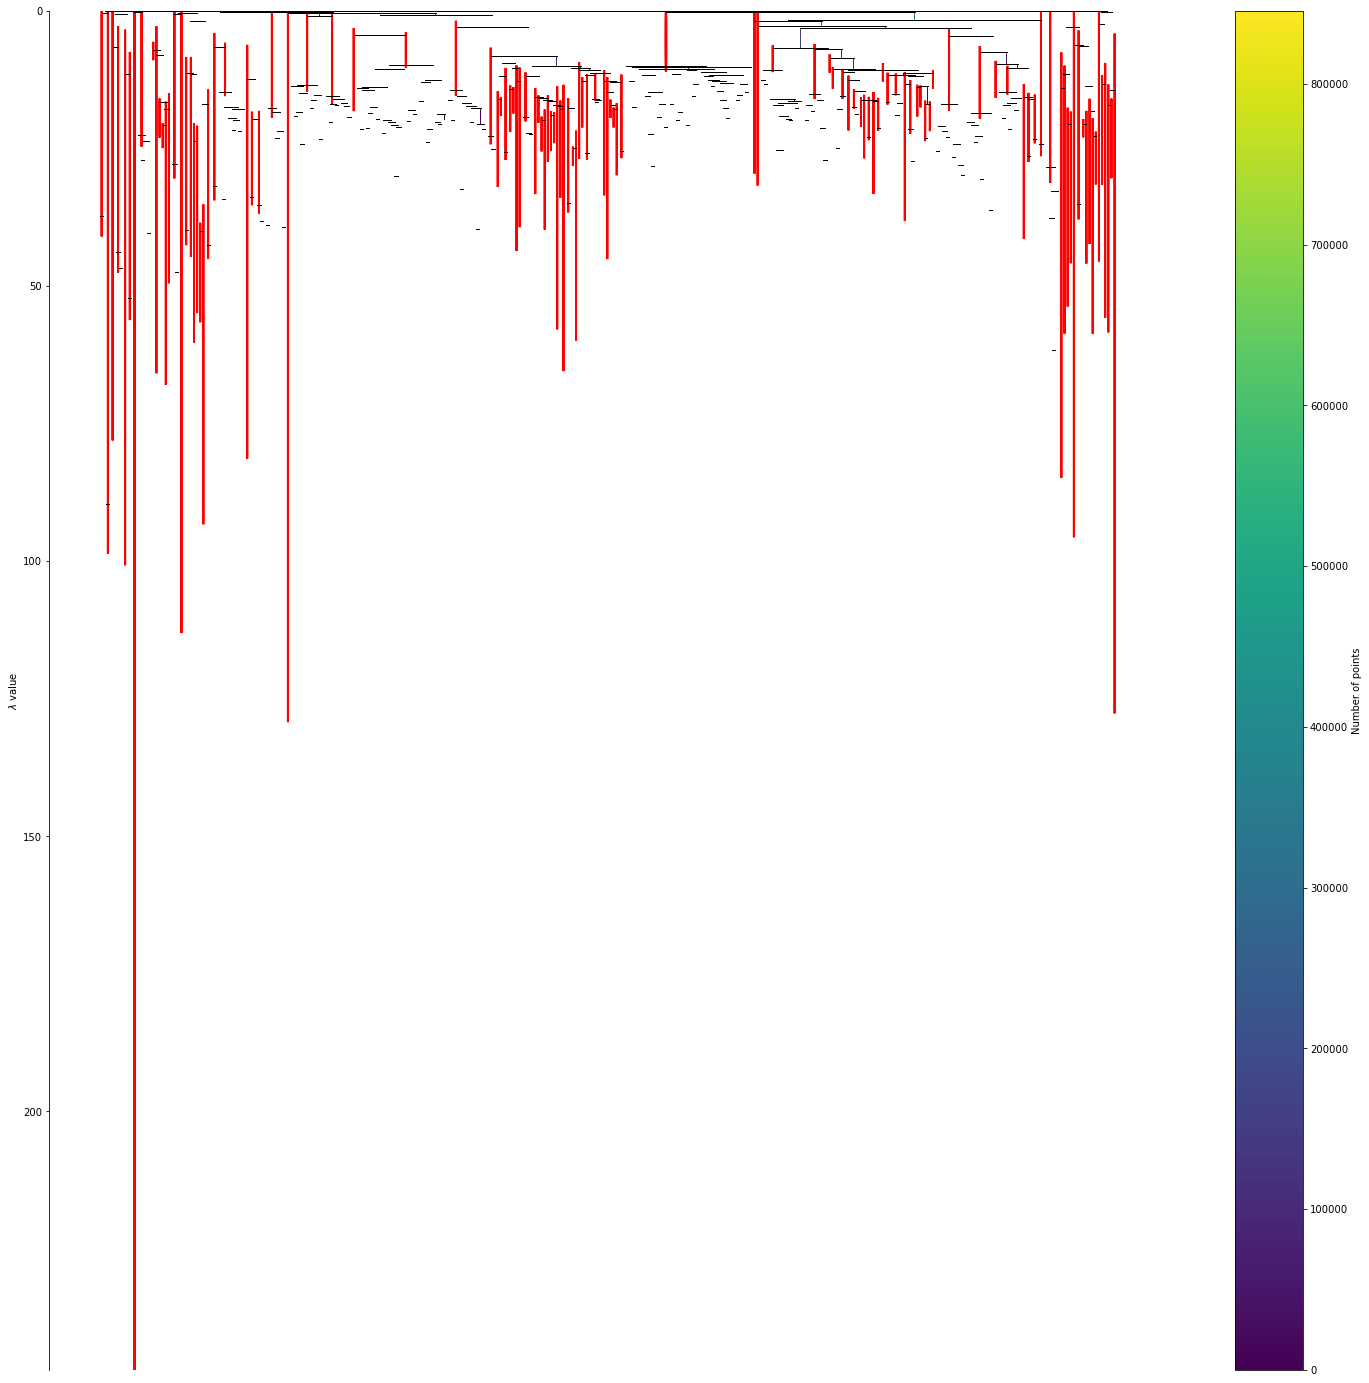

In [28]:
plt.figure(figsize=(25,25))
hbdscan_fitted.condensed_tree_.plot(label_clusters=False, log_size=False, select_clusters=True,selection_palette=sns.color_palette("Set1", 13));

In [39]:
%%time
# Caluculate Embeddings for customer dataset
customer_cluster_embeddings = umap_fitted.transform(customer_demographics_clean_sample.drop(columns=['Customer']).values)
del umap_fitted
# Determine Customer Clusters
customer_clusters = hdbscan.approximate_predict(hbdscan_fitted, customer_cluster_embeddings)  
# Updated Clusters in customer dataset
customer_demographics_clean_sample['clusters'] = customer_clusters[0]    
customer_demographics_clean_sample['clusters_prob'] = customer_clusters[1]


# Determine Population Clusters
clusters = hdbscan.approximate_predict(hbdscan_fitted, cluster_embedding)
del hbdscan_fitted
# Updated Clusters in Population dataset
population_demographics_clean_sample['clusters'] = clusters[0]
population_demographics_clean_sample['clusters_prob'] = clusters[1]

demographics_clean_sample_final = customer_demographics_clean_sample.append(population_demographics_clean_sample)
del customer_demographics_clean_sample, population_demographics_clean_sample

Wall time: 43min 15s


In [ ]:
%%time
# Evaluate segments created
cluster_labels = demographics_clean_sample_final.clusters.unique()

total_records = demographics_clean_sample_final.shape[0]
customer_prop_orig = demographics_clean_sample_final.Customer.mean()
cust_count_full = demographics_clean_sample_final.Customer.sum()
analysis_df = pd.DataFrame({'Cluster': ['All'], 'Not Customer': [(1-customer_prop_orig)*100], 'Customer': [customer_prop_orig*100], 'Per_Share_Customers': [cust_count_full*100/cust_count_full], 'Customer_Factor': [1], 'People_Count': [total_records]})

for cluster_ in cluster_labels:
    customer_prop = demographics_clean_sample_final.query("clusters == @cluster_").Customer.mean()
    cust_count = demographics_clean_sample_final.query("clusters == @cluster_").Customer.sum()    
    people_count = demographics_clean_sample_final.query("clusters == @cluster_").Customer.sum()    
    analysis_df = analysis_df.append({'Cluster': cluster_, 'Not Customer': (1-customer_prop)*100, 'Customer': customer_prop*100, 'Per_Share_Customers': cust_count*100/cust_count_full, 'Customer_Factor': customer_prop/customer_prop_orig, 'People_Count': people_count}, ignore_index=True)

analysis_df = analysis_df.sort_values(by=['Customer'], ascending=False)

Wall time: 16.4 s


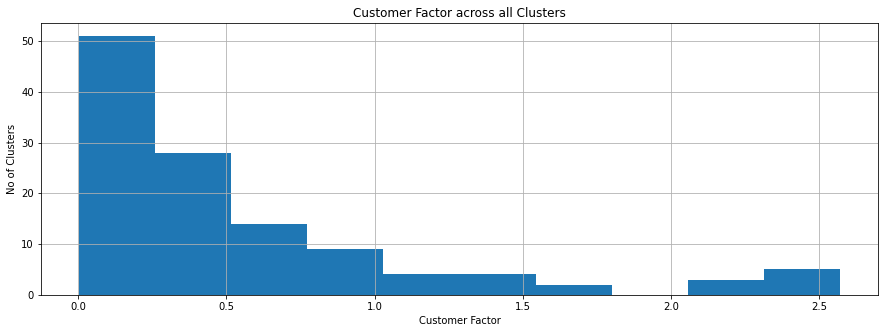

,Cluster,Not Customer,Customer,Per_Share_Customers,Customer_Factor,People_Count
8,4,61.266856,38.733144,1.455479,2.570650,2183.0
42,31,62.190083,37.809917,0.244024,2.509378,366.0
9,13,64.375830,35.624170,10.731073,2.364313,16095.0
7,14,64.649665,35.350335,9.075574,2.346139,13612.0
12,48,64.961140,35.038860,0.360703,2.325467,541.0
33,26,65.420561,34.579439,0.419375,2.294976,629.0
4,49,66.978346,33.021654,0.447378,2.191589,671.0
2,10,69.003963,30.996037,44.115078,2.057152,66166.0
13,36,73.648294,26.351706,0.334700,1.748916,502.0
46,25,73.660205,26.339795,0.308031,1.748126,462.0


In [ ]:
analysis_df.Customer_Factor.hist(figsize=(15,5))
plt.xlabel("Customer Factor")
plt.ylabel("No of Clusters")
plt.title("Customer Factor across all Clusters")
plt.show()

analysis_df.head(20)

In [50]:
clusters_above_general = analysis_df.iloc[0:19]
clusters_with_double_customers = analysis_df.iloc[0:8]

print(f"{clusters_above_general.shape[0]} Clusters are above the base line and capture about {clusters_above_general.Per_Share_Customers.sum():.2f}% of the customers from only {clusters_above_general.People_Count.sum()/total_records*100:.2f}% of the Population")
print(f"{clusters_with_double_customers.shape[0]} Clusters have double the number of customers relative to the base line and capture about {clusters_with_double_customers.Per_Share_Customers.sum():.2f}% of the customers of the customers from only {clusters_with_double_customers.People_Count.sum()/total_records*100:.2f}% of the Population")

19 Clusters are above the base line and capture about 70.93% of the customers from only 10.69% of the Population
8 Clusters have double the number of customers relative to the base line and capture about 66.85% of the customers of the customers from only 10.07% of the Population


In [51]:
# We save the demographics_clean_sample_final
demographics_clean_sample_final.to_csv(processed_dir + "demographics_clean_sample_final.csv", index=False)
analysis_df.to_csv(processed_dir + "cluster_analysis_df.csv", index=False)

## Evaluate Feature Importances

Next, we train an inferential classification model. We then use SHAP to understand the most important features for each of the 118 clusters.

In [52]:
random_seed = 22

all_columns = demographics_clean_sample_final.drop(columns=['Customer', 'clusters', 'clusters_prob']).columns.tolist()
# All columns not within the selected known set are considered ordinal or numerical columns
selected_known_columns = [col for col in all_columns if col in all_known_columns]
non_categ_features = numerical_features + ordinal_features
categ_features = [col for col in selected_known_columns if col not in non_categ_features]

In [55]:
%%time
# Build Inferential Model to explain created Clusters
X_train, X_test, y_train, y_test = train_test_split(demographics_clean_sample_final.query("Customer == 0").drop(columns=['Customer','clusters', 'clusters_prob']), demographics_clean_sample_final.query("Customer == 0")['clusters'], test_size=0.33, random_state=random_seed)

# Train and Predict 
lgbm = lgb.LGBMClassifier(random_state=random_seed, learning_rate=0.01, n_estimators=100, n_jobs=-1, verbose=1, objective='multiclass')\
    .fit(X_train, y_train, eval_set=[(X_test, y_test)], eval_metric='multi_logloss', early_stopping_rounds=20, feature_name=all_columns, categorical_feature=categ_features)
y_pred = lgbm.predict(X_test, num_iteration=lgbm.best_iteration_)

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.
categorical_feature in Dataset is overridden.
New categorical_feature is ['AGER_TYP', 'ALTERSKATEGORIE_GROB', 'ALTER_HH', 'ANREDE_KZ', 'CAMEO_DEU_2015', 'CJT_GESAMTTYP', 'D19_KONSUMTYP', 'FINANZTYP', 'GEBAEUDETYP', 'GEBAEUDETYP_RASTER', 'GEBURTSJAHR', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'HEALTH_TYP', 'KBA05_HERSTTEMP', 'KBA05_MODTEMP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_STATUS_FEIN', 'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ', 'PRAEGENDE_JUGENDJAHRE', 'RETOURTYP_BK_S', 'SHOPPER_TYP', 'TITEL_KZ', 'VERS_TYP', 'WOHNLAGE', 'ZABEOTYP']


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.607549 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3731
[LightGBM] [Info] Number of data points in the train set: 566444, number of used features: 359


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] Start training from score -2.136718
[LightGBM] [Info] Start training from score -6.733903
[LightGBM] [Info] Start training from score -5.516519
[LightGBM] [Info] Start training from score -5.958889
[LightGBM] [Info] Start training from score -6.700348
[LightGBM] [Info] Start training from score -5.490082
[LightGBM] [Info] Start training from score -7.067117
[LightGBM] [Info] Start training from score -4.567141
[LightGBM] [Info] Start training from score -5.060391
[LightGBM] [Info] Start training from score -5.389653
[LightGBM] [Info] Start training from score -5.817019
[LightGBM] [Info] Start training from score -1.747293
[LightGBM] [Info] Start training from score -4.038695
[LightGBM] [Info] Start training from score -6.756410
[LightGBM] [Info] Start training from score -3.363543
[LightGBM] [Info] Start training from score -3.527629
[LightGBM] [Info] Start training from score -6.771701
[LightGBM] [Info] Start training from score -5.771228
[LightGBM] [Info] Start trai

KeyboardInterrupt: 

In [59]:
# Plot Confusion Matrix
# cm = confusion_matrix(y_test, y_pred)
# disp = ConfusionMatrixDisplay(cm, display_labels=np.arange(-1,118))
# disp.plot(cmap="Blues", values_format='');

In [56]:
print("Classification report for Inferential Model")
print(classification_report(y_test, y_pred, digits=3))

Classification report for Inferential Model
              precision    recall  f1-score   support

          -1      0.744     0.670     0.705     33179
           0      1.000     1.000     1.000       349
           1      1.000     0.997     0.999      1091
           2      0.999     0.999     0.999       749
           3      0.926     0.947     0.936       341
           4      0.984     0.978     0.981      1115
           5      1.000     1.000     1.000       255
           6      1.000     0.998     0.999      2788
           7      0.997     0.999     0.998      1758
           8      0.997     1.000     0.998      1281
           9      0.996     0.993     0.995       769
          10      0.993     0.998     0.995     48600
          11      0.990     0.994     0.992      4899
          12      0.973     0.828     0.895       303
          13      0.982     0.990     0.986      9479
          14      0.994     0.984     0.989      8255
          15      0.929     0.990    

In [58]:
%%time
# Explain Model using Shap
max_data_points = 50_000

explainer = shap.TreeExplainer(lgbm)
shap_values = explainer.shap_values(X_train[:max_data_points])

Wall time: 17min 6s


In [101]:
## Couldn't save to local memory due to memory issues
# with open(processed_dir + f'shap_values_{max_data_points}.pkl', mode='wb') as fp:
#     cPickle.dump(shap_values, fp)

In [ ]:
# This failed to plot due to memory issues

# Plot Summary Plot
shap.summary_plot(shap_values, X_train[:max_data_points], class_names=np.arange(-1,6), plot_type='bar', max_display=15, plot_size=(25, 10), feature_names=all_columns)

In [71]:
# Plot Summary Plot
def plot_cluster_summary_plot(cluster_no, no_of_features=5, plot_type='bar', shap_values=shap_values, X_train=X_train, max_data_points=max_data_points, all_columns=all_columns):
    """
    This method plots a summary plot for a single cluster
    
    :param cluster_no:
    :param no_of_features: No of features to plot
    :param plot_type:
    :param shap_values: Generated Shaply Values
    :param X_train:
    :param max_data_points:
    :param all_columns: List of column names that were in the training dataset
    :return: None
    """ 
    fig, axes = plt.subplots(1,1, figsize=(5, 5))

    shap.summary_plot(shap_values[cluster_no], X_train[:max_data_points], plot_type=plot_type, show=False, max_display=no_of_features, plot_size=(10, 5), feature_names=all_columns)
    axes.set_title(f"Cluster {np.arange(-1,118)[cluster_no]} Summary Plot")
    plt.show()

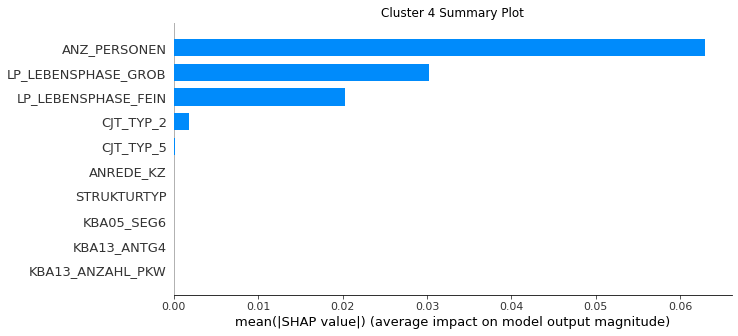

In [80]:
plot_cluster_summary_plot(5, no_of_features=10)

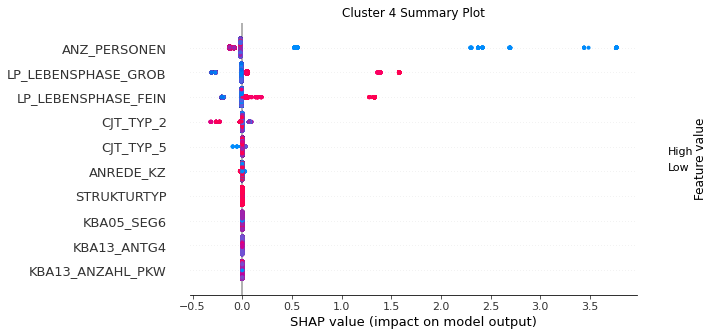

In [75]:
plot_cluster_summary_plot(5, no_of_features=10, plot_type='dot')

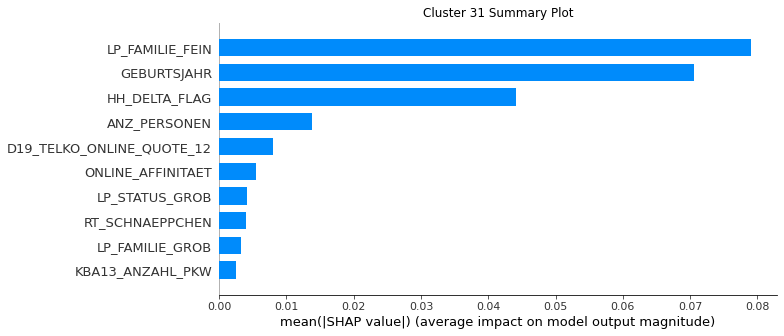

In [79]:
plot_cluster_summary_plot(32, no_of_features=10)

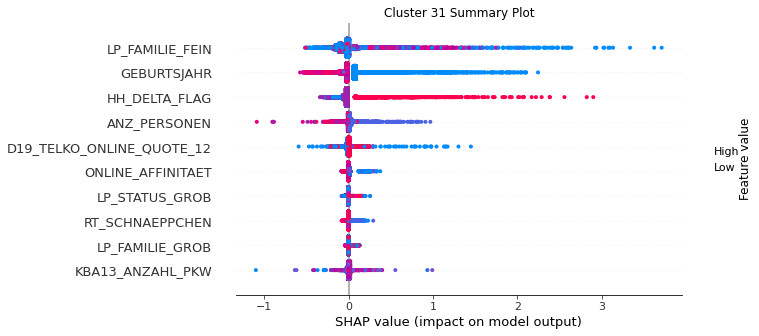

In [76]:
plot_cluster_summary_plot(32, no_of_features=10, plot_type='dot')

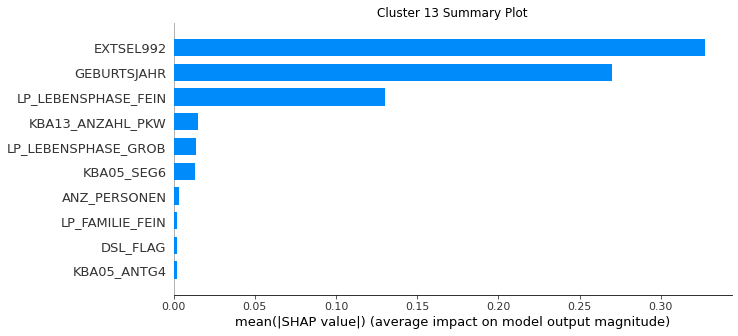

In [81]:
plot_cluster_summary_plot(14, no_of_features=10)

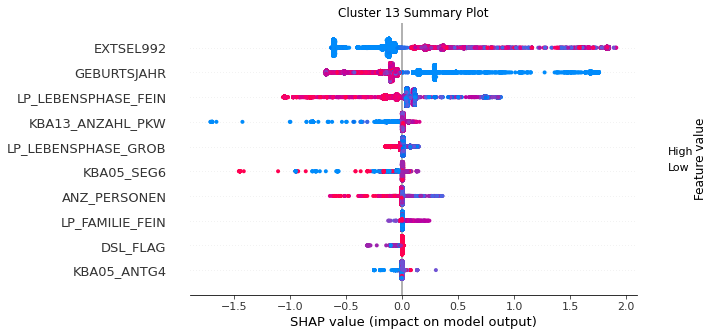

In [82]:
plot_cluster_summary_plot(14, no_of_features=10, plot_type='dot')

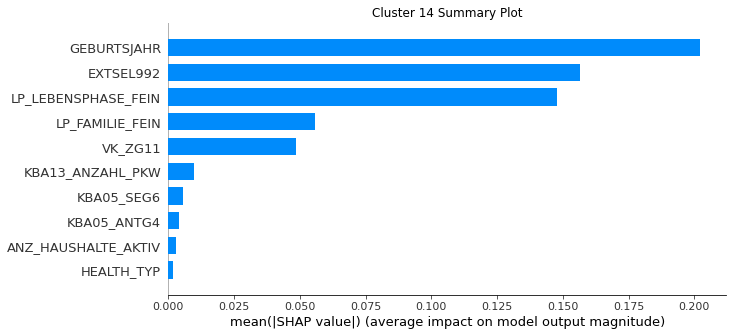

In [84]:
plot_cluster_summary_plot(15, no_of_features=10)

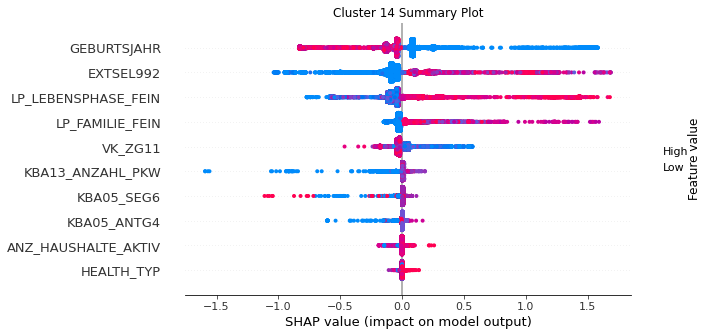

In [85]:
plot_cluster_summary_plot(15, no_of_features=10, plot_type='dot')

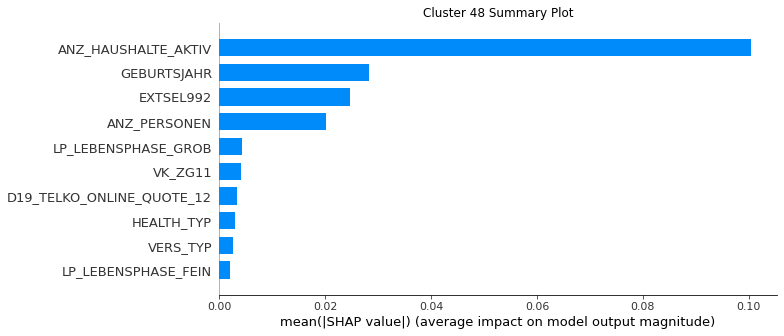

In [86]:
plot_cluster_summary_plot(49, no_of_features=10)

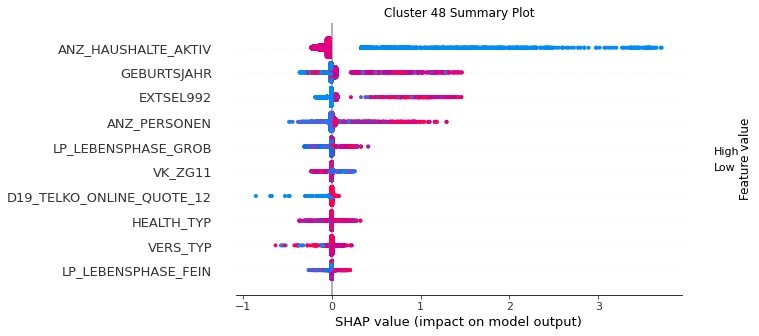

In [87]:
plot_cluster_summary_plot(49, no_of_features=10, plot_type='dot')

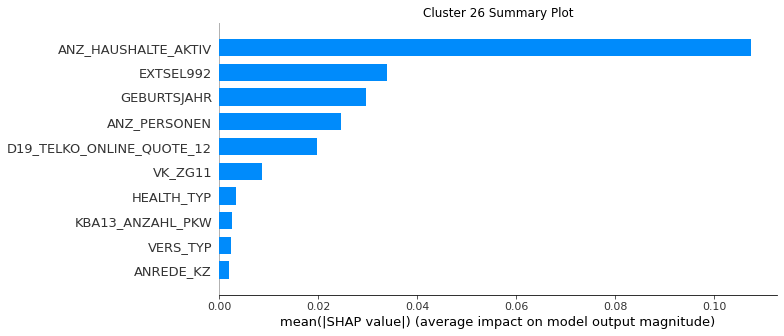

In [88]:
plot_cluster_summary_plot(27, no_of_features=10)

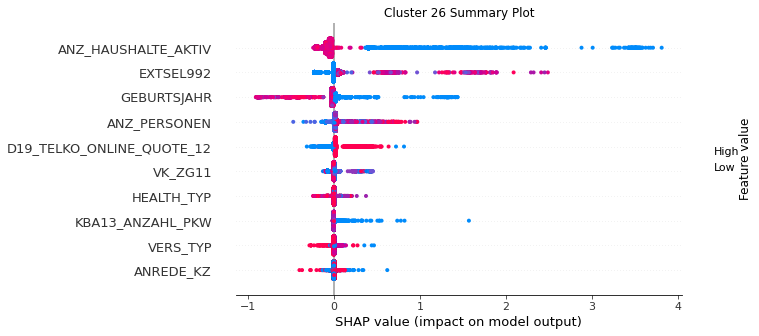

In [89]:
plot_cluster_summary_plot(27, no_of_features=10, plot_type='dot')

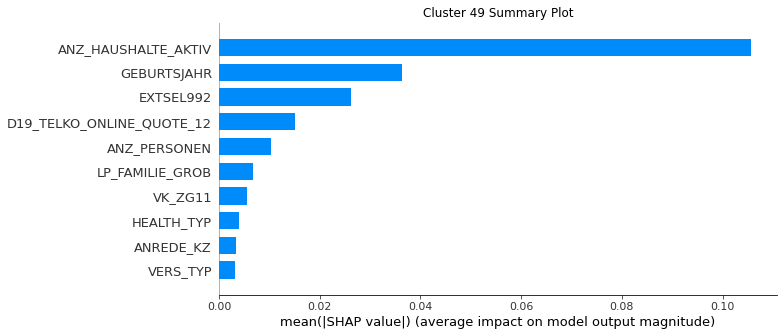

In [90]:
plot_cluster_summary_plot(50, no_of_features=10)

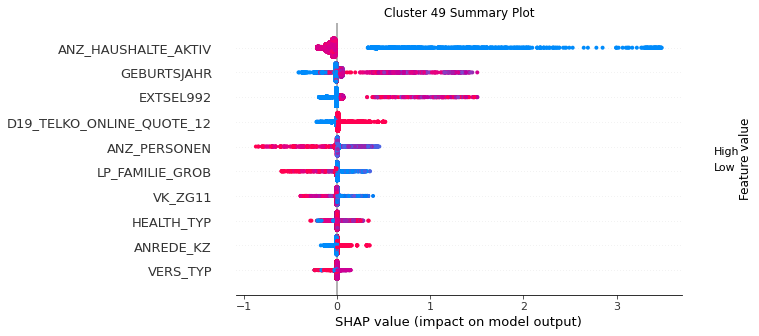

In [91]:
plot_cluster_summary_plot(50, no_of_features=10, plot_type='dot')

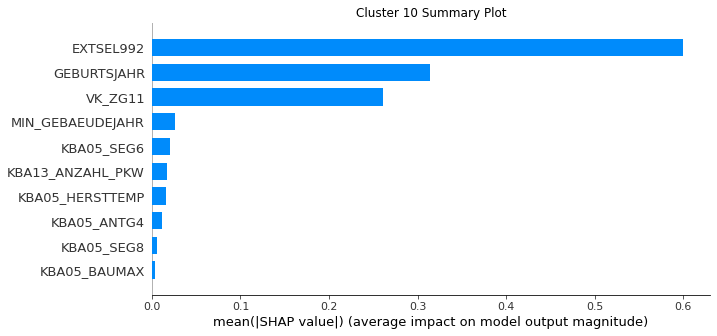

In [92]:
plot_cluster_summary_plot(11, no_of_features=10)

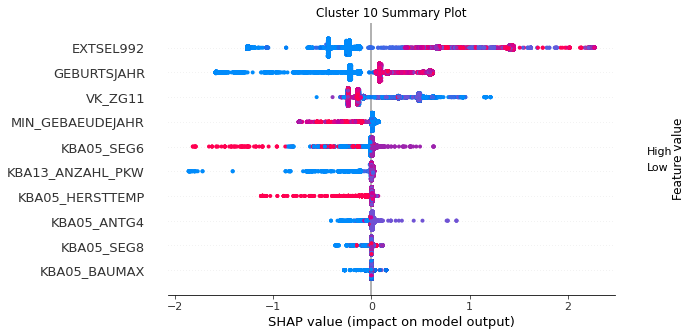

In [93]:
plot_cluster_summary_plot(11, no_of_features=10, plot_type='dot')

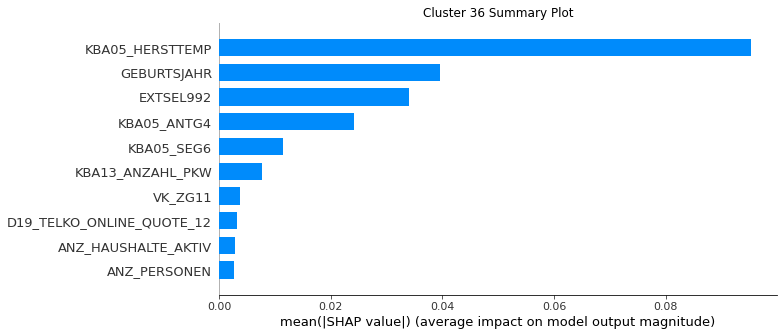

In [94]:
plot_cluster_summary_plot(37, no_of_features=10)

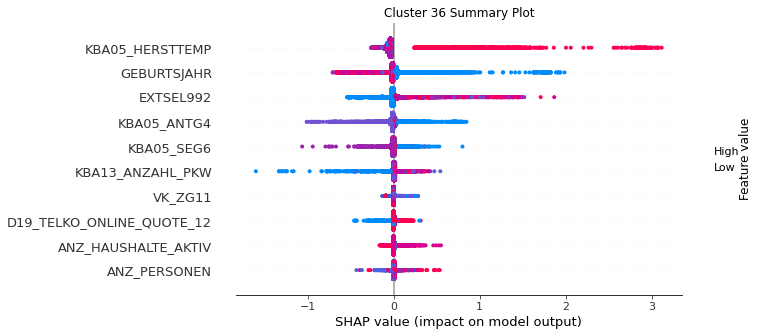

In [95]:
plot_cluster_summary_plot(37, no_of_features=10, plot_type='dot')

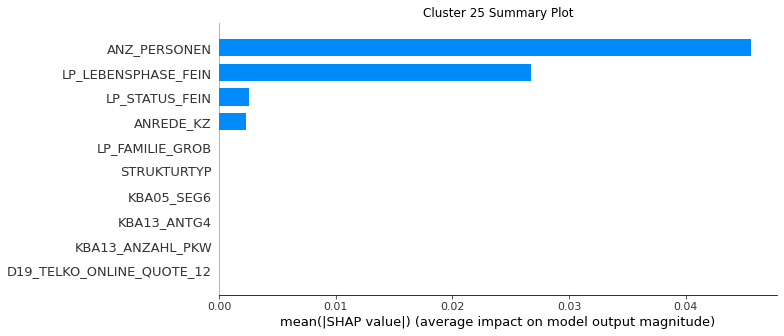

In [103]:
plot_cluster_summary_plot(26, no_of_features=10)

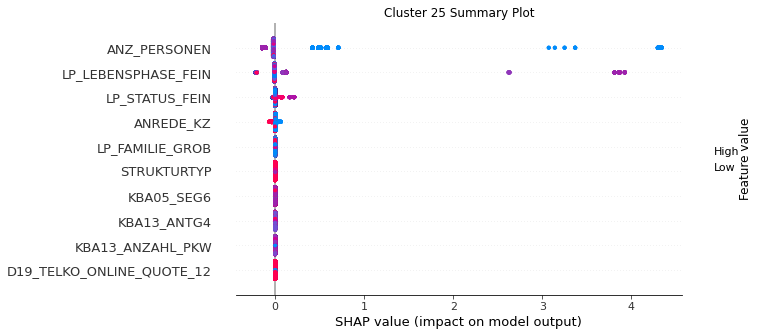

In [104]:
plot_cluster_summary_plot(26, no_of_features=10, plot_type='dot')

In [106]:
del explainer, shap_values

Comments:
- Weighted Average performance of the inferential model is 99.2% F1-score. So it's is can give reliable insights on the large clusters i.e. **Cluster 1,5 and 0** and the Noise
- Large Clusters:
    - Cluster 1: Based on KBA13_ANZAHL_PKW, high/low number of cars in the PLZ8
    - Cluster 5: Based on ANZ_PERSONEN, high/low number of people in the household.
    - Cluster 0: Based on KBA05_SEG6, high/low no of upperclass cars in microcell
- Noise: No clear dominant feature in this cluster.
- Not Important:
    - Cluster 4: Based on ANZ_HAUSHALTE_AKTIV, no of households in this building
    - Cluster 3 & 2: Top feature is the same for both. OST_WEST_KZ i.e Flag indicating formerly in West/East Germany